# Lekce 4

Základní otázkou je, proč se statistikou vůbec zabýváme a co statistika nabízí navíc oproti datové analýze. Hlavní rozdíl mezi statistikou a datovou analýzou je, že u statistiky se zpravidla zabýváme vzorkem dat a na základě vzorku dat usuzujeme, jaké má vlastnosti nějaký větší celek.

Uvažujme například informace z vyřešení pacientů, která se týkají cukrovky.

Dnes budeme používat soubor [diabetes.csv](diabetes.csv). Zdoj dat: [National Institute of Diabetes and Digestive and Kidney Diseases/kaggle.com](https://www.kaggle.com/datasets/mathchi/diabetes-data-set/)

## Základní statistické ukazatele

Máme-li k dispozici nějaký soubor dat, často nás zajímají různé statistické ukazatele. Nejčastěji nás zajímají ukazatele **úrovně (polohy)** a ukazatele **variability**. Ty s přehledem zvládne například modul `statistics`, který je součástí základních modulů Pythonu. My pro zpracování dat využijeme modul `pandas`.

Budeme využívat data o vyšetření pacientek, která jsou v souboru `diabetes.csv`.

* Pregnancies: Počet těhotenství
* Glucose: Koncentrace glukózy v plazmě 2 hodiny po perorálním glukózovém tolerančním testu
* BloodPressure: Diastolický krevní tlak (mm Hg)
* SkinThickness: Tloušťka kožního záhybu na tricepsu (mm)
* Insulin: 2-hodinový sérový inzulín (mu U/ml)
* BMI: Index tělesné hmotnosti (hmotnost v kg/(výška v m))
* DiabetesPedigreeFunction: Diabetická rodokmenová funkce
* Age: Věk (roky)

In [4]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns

data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
labels = {0: "no", 1: "yes"}
data["Outcome"] = data["Outcome"].map(labels)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,yes
1,1,85,66,29,0,26.6,0.351,31,no
2,8,183,64,0,0,23.3,0.672,32,yes
3,1,89,66,23,94,28.1,0.167,21,no
4,0,137,40,35,168,43.1,2.288,33,yes


### Průměr a medián

Nejznámější ukazatele polohy jsou **aritmetický průměr** a **medián**. Aritmetický průměr je součet hodnot vydělený jejich počtem, medián získáme jako prostřední hodnotu u dat seřazených podle velikosti. Platí, že medián je méně citlivý na tzv. **odlehlá pozorování (outliers)**, v našem případě by to byly extrémně drahé nebo naopak levné domy.

Průměr zjistíme pomocí metody `mean()` a medián pomocí metody `median()`, metody použijeme pro sloupeček `BloodPressure`, tj. pro krevní tlak.

In [6]:
print(data["BloodPressure"].mean())
print(data["BloodPressure"].median())

69.10546875
72.0


## Statistické hypotézy

Hypotézou obecně myslíme nějaké tvrzení. Testování hypotéz se zabývá ověřením, zda je nějaká hypotéza platná. Při testování hypotéz předpokládáme, že máme k dispozici nějaký vzorek dat, nikoli kompletní data. To vnáší prvek určité nejistoty.

Uvažujme, že naším záměrem je zjistit, jestli se liší tlak krve u žen s cukrovkou a u žen bez ní.

Podívejme se nejprve, kolik dat máme v každé skupině.

In [7]:
data["Outcome"].value_counts()

Outcome
no     500
yes    268
Name: count, dtype: int64

Podívejme se nyní na průměrné tlaky krve v obou skupinách. Nejprve si rozdělíme data do samostatných tabulek (bylo by možné využít i agregaci, ale data stejně musíme rozdělit, tak to udělejme nyní).

In [8]:
data_yes = data[data["Outcome"] == "yes"]
data_no = data[data["Outcome"] == "no"]

Podívejme se nejprve na tlak žen, které cukrovkou trpí.

In [9]:
data_yes["BloodPressure"].mean()

70.82462686567165

Nyní se podívejme na tlak žen, které cukrovku nemají.

In [10]:
data_no["BloodPressure"].mean()

68.184

Data si můžeme porovnat i graficky. Šedá linka, kterou zobrazuje `barplot()`, je tzv. interval spolehlivosti, tj. interval, kde se dle odhadu nachází 95 % hodnot.

<Axes: xlabel='Outcome', ylabel='BloodPressure'>

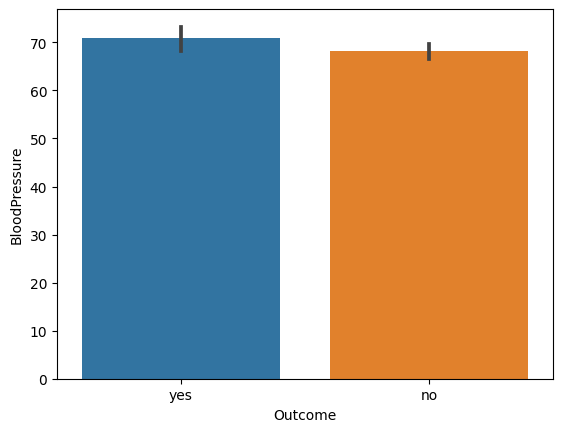

In [11]:
sns.barplot(data, x="Outcome", y="BloodPressure")

Vidíme, že průměrná hodnota se liší. Musíme ale myslet na to, že máme jen omezený vzorek (768 žen), takže musíme být opatrní, pokud bychom chtěli formulovat nějaký obecný závěr na všechny ženy v populaci. Můžeme se výsledky podívat ze dvou směrů:

- "Čísla vyšla různě, tím pádem musí být průměr jiný."
- "Ten rozdíl je malý a máme jen vzorek 768, takže to nejspíše bude náhoda."

Ke které z těchto stran bychom se měli přiklonit? V řadě případů není možné se intuitivně přiklonit na jednu stranu. Právě tento problém za nás řeší testování hypotéz.

Testování hypotéz má pevný postup, který se skládá z následujících kroků:

* Formulace statistických hypotéz.
* Výběr vhodného testu.
* Výpočet hodnoty testového kritéria.
* Rozhodnutí o platnosti nulové hypotézy.

### Formulace statistických hypotéz

Při testování hypotéz vždy nejprve definujeme dvě hypotézy - **nulovou** a **alternativní**. Tyto dvě hypotézy musí být vždy **ve sporu**, tj. nemůže nastat situace, že by byly obě pravdivé. Nulová hypotéza v sobě má často znaménko *rovná se*, alternativní pak mívá znaménko *nerovná se*, *větší než* nebo *menší než*. Dále můžeme v nulové hypotéze tvrdit, že mezi dvěma sloupci v tabulce není závislost, a alternativní hypotéza bude říkat, že závislost existuje.

Navažme na předchozí lekci, kde jsme měřili sílu statistické závislosti mezi cenou domu a obytnou plochou. Hodnotu korelačního koeficientu sice známe, ale ta nám toho sama o sobě tolik neřekne. Nyní budeme chtít ověřit, že je vliv velikosti obytné plochy na cenu domu **statisticky významný**, tj. rozhodneme, zda tento vliv není čistě náhodný. 

Uvažujme následující dvojici hypotéz:

- Nulová hypotéza: Ženy trpící cukrovkou mají v průměru (*ve střední hodnota*) stejný krevní tlak jako ženy, které cukrovkou netrpí
- Alternativní hypotéza: Ženy trpící cukrovkou mají v průměru (*ve střední hodnota*) jiný krevní tlak jako ženy, které cukrovkou netrpí

Při formulování statistických hypotéz (a ve statistice obecně) obvykle rozlišujeme mezi dvěma pojmy:

- Průměr = to, co jsme spočítali z našich dat.
- Střední hodnota = hodnota, která se vztahuje k celé populaci (například ke všem ženám na světě). Střední hodnotu neznáme, ale odhadujeme ji pomocí průměru.

Je zřejmé, že obě hypotézy nemohou být pravidivé. Při testování hypotéz můžeme dojít k následujícím závěrům:

* zamítáme H0 (a tedy tvrdíme, že platí H1),
* nezamítáme H0 (a tedy jsme neprokázali, že platí H1).

Poněkud nepříjemnou zprávou pro vás může být informace, že výsledek našeho testu může být chybný, a to i v případě, že jsme postuovali správně. Může se totiž stát, že prostě máme smůlu na náš vzorek, který nereprezentuje data o celé populaci úplně správně.

Při testování se můžeme dopustit 2 chyb, které jsou popsány v tabulce níže.

|   | Krevní tlak se neliší | Krevní tlak se liší |
|---|---|---|
| **Neprokázali jsme závislost** | Správný výsledek | Chyba II. druhu |
| **Tvrdíme, že cena a plocha jsou závislé**  | Chyba I. druhu | Správný výsledek |

Rozepišme si nyní tyto chyby obecně

|   | Nulová hypotéze platí | Nulová hypotéza neplatí |
|---|---|---|
| **Nezamítáme nulovou hypotézu** | Správný výsledek | Chyba II. druhu |
| **Zamítáme nulovou hypotézu**  | Chyba I. druhu | Správný výsledek |

Při testování hypotéz si zpravidla vybíráme pravděpodobnost, s jakou se chceme dopustit chyby I. druhu. Pravděpodobnost chyby I. druhu označujeme jako **hladinu významnosti**.

## Výběr vhodného testu

Dále zvolíme vhodný test pro ověření naší hypotézy. Statistických testů existuje obrovské množství a výběr toho správného závisí obecně na několika faktech:

- Počet souborů (skupin) dat, se kterými chceme v testu pracovat. V tomto konkrétním případě chceme pracovat se dvěma soubory, můžeme mít ale pouze jeden či naopak 3 a více. Soubory myslíme "skupiny", které v testu porovnáváme. V našem testu máme dvě skupiny - ženy trpící cukrovkou a ženy, které cukrovku nemají. Nejde o to, kolik dat máme pro každou ze skupin. Mohli bychom mít například milion záznamů o ženách s cukrovkou a milion záznamů o ženách bez ní, ale pořád by šlo o dva soubory.
- Statistický ukazatel nebo skutečnost, kterou chceme ověřit. V našem případě půjde o průměr, ale je možné testovat i jiné skutečnosti.
- Předpoklady testu. Předpoklad je nějaká podmínka, která musí být splněna, aby test dával kvalitní výsledky. O tom si více povíme příště.

Vraťme se k našemu testu. Chceme porovnat průměry ve dvou souborech. Pro tento případ existuje několik testů, my zvolíme test označovaný jako **t-test**.

Samotný výpočet můžeme provést s využitím modulu `scipy`, konkrétně funkce `stats.ttest_ind`.

In [12]:
stats.ttest_ind(data_yes["BloodPressure"], data_no["BloodPressure"])

Ttest_indResult(statistic=1.8047023017353887, pvalue=0.07151390009776082)

Co tato záhadná čísla znamenají?

- `statistics` je hodnota statistiky testu. Statistika testu je v podstatě matematický vzoreček. V tomto případě číslo říká, jak moc pořadí pozorování v jednom souboru odpovídá pořadí pozorování ve druhém souboru.
- `pvalue` (p-hodnota) se váže k hladině významnosti. p-hodnotu využijeme pro rozhodnutí o platnosti alternativní hypotézy.

Platí následující **obecná** pravidla.

- Pokud je **p-hodnota menší než hladina významnosti, zamítáme nulovou hypotézu** (tj. platí alternativní hypotéza).
- Pokud je **p-hodnota větší než hladina významnosti, nezamítáme nulovou hypotézu.**

Pokud si zvolíme hladinu významnosti jako 5 %, což je nejčastější volba, můžeme zapsat pravidlo konkrétněji.

- Pokud je **p-hodnota < 0.05, zamítáme nulovou hypotézu** (tj. platí alternativní hypotéza).
- Pokud je **p-hodnota > 0.05, nezamítáme nulovou hypotézu.**

V našem případě je p-hodnota `0.07151390009776082`. Číslo je vyšší než 0.05. I když jsme tedy zjistili různou hodnotu průměrného tlaku, nemůžeme trvdit, že by obecně měly ženy trpící cukrovkou jiný tlak než ženy bez ní. Zjištěný rozdíl je příliš malý.

Cukrovka může souviset i s hmotností. Zkusme nyní zopakovat postup pro porovnání průměrné hmotnosti pacientek trpících cukrovkou a pacientech, které cukrovkou netrpí. Začneme formulací hypotéz.

- Nulová hypotéza: Ženy trpící cukrovkou mají v průměru stejnou hmotnost jako ženy, které cukrovkou netrpí
- Alternativní hypotéza: Ženy trpící cukrovkou mají v průměru jinou hmotnost jako ženy, které cukrovkou netrpí

Protože opět porovnáváme průměr dvou různých souborů, použijeme t-test. Opět využijeme funkci `ttest_ind()` z modulu `scipy`.

In [13]:
stats.ttest_ind(data_yes["BMI"], data_no["BMI"])

Ttest_indResult(statistic=8.47183994786525, pvalue=1.2298074873116022e-16)

Nyní vychází p-hodnota `1.2298074873116022e-16`. Důležité je především nenápadné číslo `e-16`. Co znamená? Číslo je zobrazené v takzvaném vědeckém formátu, což znamená, že vidíme první nenulové číslo za desetinnou čárkou a `e-16` nám říká, na kolikáté pozici za desetinnou čárkou tato číslice je. Uložme si nejprve výsledky do proměnných. Protože máme dva výsledky, připravíme si dvě proměnné - proměnnou `statistics` pro statistiku testu a `pvalue` pro p-hodnotu.

In [14]:
statistics, pvalue = stats.ttest_ind(data_yes["BMI"], data_no["BMI"])

Nyní můžeme použít funkci `format_float_positional` z modulu `numpy`, abychom zobrazil výsledek jako desetinné číslo. Vidíme, že za desetinnou čárkou je obrovské množství nul a až poté se objevuje číslo 1. Určitě je tedy p-hodnota menší než 0.05.

In [15]:
np.format_float_positional(pvalue)

'0.00000000000000012298074873116022'

Můžeme tedy formulovat závěr, že průměrný hodnota indexu BMI se liší pro ženy trpící cukrovkou a pro ženy, které cukrovkou netrpí.

Pozor ovšem na to, abychom závěry nezkresili. Pouze na základě našeho výzkumu nemůžeme tvrdít, že vyšší hmotnost vede k cukrovce. Je totiž teoreticky možné, že cukrovka způsobuje pomalejší odbourávání tuků.

Formulace hypotéz a výběr testu je na celém testování hypotéz nejtěžší. Pomocí nám může například nástroj ChatGPT. Zkusme mu zadat dotaz: *"Mám data o pacientkách, z nichž část trpí cukrovkou a část ne. V datech je i informace o krevním tlaku každé z pacientek. Chci statisticky ověřit, jestli se krevní tlak pacientek s cukrovkou liší od těch, které cukrovku nemají. Formuluj statistické hypotézy."*

Níže vidíme odpověď.

![chatgpt.png](chatgpt.png)

Všimněte si symbolu $\mu$. Jde o řecké písmeno "mí", které se ve statistice používá pro střední hodnotu.

### A/B testování

Jednou z možných aplikací t testu je tzv. A/B testování. Jde o metodu experimentálního testování, která se používá k porovnání dvou různých verzí webové stránky, aplikace, newsletteru nebo jiného produktu, aby se určilo, která z nich dosahuje lepších výsledků vůči určenému cíli. A/B testování si vyzkoušíme na datech ze serveru [DataCamp](https://app.datacamp.com/learn/projects/184) (odkaz na [kaggle.com](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing/data)), která jsou uložená v souboru [cookie_cats.csv](cookie_cats.csv).

Budou nás zajímat tyto sloupce:

- `version` - skupina uživatele (uživatelky), máme skupiny gate_30 a gate_40.
- `retention_1` - udává informaci, jestli se uživatel (uživatelka) vrátil(a) jeden den po instalaci.

In [16]:
data = pd.read_csv("cookie_cats.csv")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Opět si definujeme hypotézy:

- H0: Průměrný počet hráčů, kteří se vrátili po 1 dni, je v obou skupinách stejný.
- H1: Průměrný počet hráčů, kteří se vrátili po 1 dni, je ve skupinách rozdílný.

A provedeme test.

In [17]:
data_gate_30 = data[data["version"] == "gate_30"]
data_gate_40 = data[data["version"] == "gate_40"]
statistics, pvalue = stats.ttest_ind(data_gate_30["retention_1"], data_gate_40["retention_1"])
pvalue

0.07441111525563184

Protože p-hodnota je vyšší než 0.05, na běžně používané hladině významnosti bychom nulovou hypotézu nezamítli. Jinými slovy, neprokázali jsme, že by rozdíl v návratu hráčů ke hře pro obě skupiny nebyl náhoda.

## Kvantily

Čast používaný pojem ve statistice je kvantil. Vraťme se k našim datům o cukrovce a mediánu. Medián je číslo, pro které platí, že polovina hodnot v daném souboru je menší a polovina je větší. Podobné číslo bychom ale našli i pro jiná procenta. Uvažujme například tzv. dolní kvartil. Jedná se číslo, pro které platí, že 25 % hodnot v soubou je menších (a tím pádem 75 % je větších). Pro horní kvartil je to naopak, 75 % je menších a 25 % větších. Obecně takovým číslům říkáme **kvantil**.

Na grafu vidíme:

- Medián (čára uprostřed).
- Kvartily (tvorí barevný obdelník, dolní hranice obdelníku je dolní kvartil a horní hranice obdélníku horní kvartil).
- Poslední jsou čáry označené jako `whis` (od slova whisker - kočičí vousy). Ty zobrazují rozsah ještě větší části hodnot. Nastavme ho tak, aby označoval 90 % všech hodnot, tj. hodnoty mezi 5%ním a 95%ním kvantilem.

Z grafu je zřejmé, že "obdélník" u pacientek s cukrovkou je vyšší. Je tedy možné, že nemoc ovlivňuje množství glokózy v krvi pacientek tak, že je více různorodé.

<Axes: xlabel='Outcome', ylabel='Glucose'>

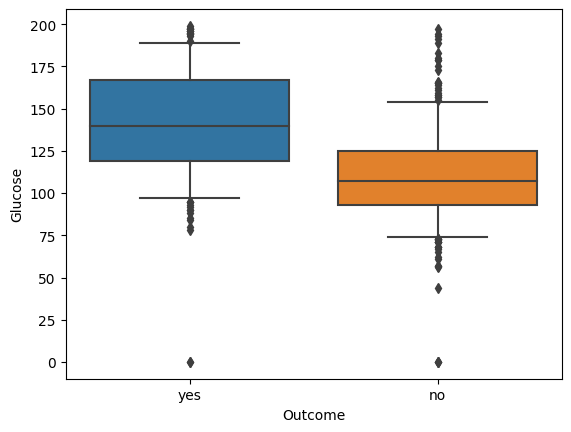

In [18]:
data = pd.read_csv("diabetes.csv")
labels = {0: "no", 1: "yes"}
data["Outcome"] = data["Outcome"].map(labels)
sns.boxplot(data, x="Outcome", y="Glucose", whis=[5, 95])

Přesné hodnoty kvantilů můžeme též získat s využitím funkce `quantile` z modulu `numpy`.

In [20]:
np.quantile(data_yes["Glucose"], 0.25)

119.0

In [21]:
np.quantile(data_yes["Glucose"], 0.75)

167.0

Nyní víme, že hladina glukózy u 50 % pacientek se pohybuje mezi 119 a 167.

## Cvičení

## Důvěra v EU a euro

Tentokrát budeme pracovat s daty z výzkumu veřejného mínění Eurobarometr. Ten je realizován v zemích Evropské unie a lidé jsou v něm pravidelně tázání na řadu otázek. My se podíváme na jednu z nich. Rozdělíme státy EU na dvě skupiny - státy v eurozóně a státy mimo ni. Jak je to s důvěrou v EU? Důvěřují EU více lidé, kteří žijí ve státech platící eurem? Využij znovu data o důvěře v EU ze souboru [duvera.csv](duvera.csv) a rozděl státy na ty, které jsou v eurozóně, a ty, které jsou mimo ni.

Použij sloupce `EU Trustt` (důvěra v EU) a `Euro` (jestli má země euro).

Aplikuj postup, který jsme si ukázali v lekci, tj. formuluj hypotézy, určitě p-hodnotu a rozhodni o výsledku testu.

Zdroj dat: [https://europa.eu/eurobarometer/screen/home](https://europa.eu/eurobarometer/screen/home)

In [ ]:
data = pd.read_csv("inflace.csv")
data.head()

,Country,98,97,Country Name,Euro
0,BE,31,34,Belgium,1
1,BG,22,31,Bulgaria,0
2,CZ,34,42,Czechia,0
3,DK,28,33,Denmark,0
4,DE,33,40,Germany,1


## Bonus: Inflace

V souboru [inflace.csv](inflace.csv) najdeš procenta lidí, kteří považují inflaci a růst životních nákladů za jeden ze svých nejzávažnějších problémů. Data jsou za dvě období - léto 2022 (sloupec `97`) a zima 2022/2023 (sloupec `98`). Ověř, zda se procento lidí, kteří řadí inflaci mezi 2 své nejzávažnější problémy, změnilo.

Jedná se o tzv. párová data. Máme totiž dva údaje pro každý stát. Jinak řečeno, ke každé hodnotě ze sloupečku `97` patří jedna konkrétní hodnota ze sloupečku `98` (vždy jde o hodnoty pro ten samý stát). Pro taková data je vhodnější použití [párového testu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel). Pro párový test formulujeme stejné hypotézy jako u nepárového. Rozdíl je v tom, že pro párové pozorování vypočtená p-hodnota přesnější.

Aplikuj postup, který jsme si ukázali v lekci, tj. formuluj hypotézy, určitě p-hodnotu a rozhodni o výsledku testu.

In [ ]:
data = pd.read_csv("duvera.csv")
data.head()

,Country,National Government Trust,EU Trust,Country Name,Euro
0,BE,40,55,Belgium,1
1,BG,19,49,Bulgaria,0
2,CZ,30,43,Czechia,0
3,DK,52,65,Denmark,0
4,DE,49,49,Germany,1
